## Value-at-Risk Computation for a portefolio using Monte Carlo

[Value at risk (VaR)](https://en.wikipedia.org/wiki/Value_at_risk) is a measure of the risk of loss for investments. It estimates how much a set of investments might lose (with a given probability), given normal market conditions, in a set time period such as a day. VaR is typically used by firms and regulators in the financial industry to gauge the amount of assets needed to cover possible losses.

![](https://meritis.fr/wp-content/uploads/2018/10/VaR_1.png)


Technical report ( in french) could be find [here](https://docs.google.com/document/d/1viXKQ3nX7416jMxwU3KO_WuKwwTz0pgZ7NWmUAMk8cg/edit?usp=sharing) 


# 1. Simulate Assets and Portfolio


### Problem definition

Let $S^k$, $k=\overline{1,K}$ , risky financial assets. Following at each $t$, Geometric Brownian Motion: $S_t^{k}= S_0^{k}e^{(\mu_{k}-\sigma_{k}^{2})t+\sigma_{k}W_{t}^{k}}$ <br/>
Where : <br/>
$\mu_{k}$ : drift rate<br/>
$\sigma_{k}$ : volatility<br/>
$W_{t}$ : Weiner process <br/>

Let $V_{t}=\sum_{k=1}^{K} \lambda_{k}S_{t}^{k}$ be portefolio of several number or assets.<br/>
Let $L_{t}=V_{0}-V_{t}$, loss a time $t$. <br/>

Value-at-Risk is defined by :  $VaR = \mathbb{P}(L_{t} > H)$ , with $H$ maximal expected loss.

In [85]:
// Asset model
K = 3;      
SIG = 0.5*eye(K,K) + 0.5*ones(K,K); 

S_0 = ones(K,1);
mu = ones(K,1);
sigma = ones(K,1);

S_0(3) = 0 ;
mu(1) = 0 ;

// Portfolio Model 
lambda = -ones(K,1);
V0=lambda'*S_0;
H=0.10*V0;

// Simulation params
T = 0.1;   // Final time
N = 1000;  // Sampling 
step = T/(N-1);
t = 0:step:T;

### Generate Weiner Process

In [86]:
G=zeros(K,N);

// Box-Muller simulation of pair of N(0,1)

for i = 1:(ceil(K/2)) 
    
    UU = rand(1,N,'unif'); 
    VV = rand(1,N,'unif'); 

    G(i,:) = sqrt(-2*log(UU)).*cos(2*%pi*VV);
    G(i+1,:) = sqrt(-2*log(UU)).*sin(2*%pi*VV);
end  

// Add Covariance using Cholesky method

Z = chol(SIG)' * G(1:K,:); 

// Obtain Weiner process 

W=zeros(K,N);

for i = 2:N
    W(:,i) = W(:,i-1) + sqrt(step)*Z(:,i);
end;

### Compute  Portefolio Loss



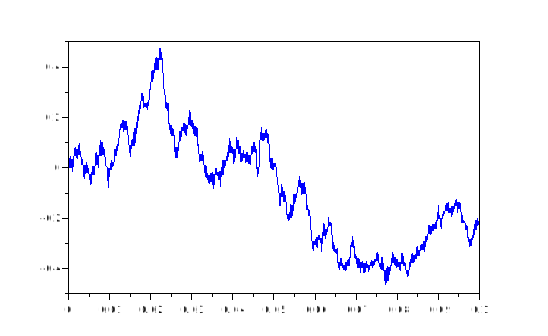

In [87]:
S = zeros(K,N);
V = zeros(1,N);
L = zeros(1,N);

// Compute Assets and Portefolio

for i = 1:K
 S(i,:) = lambda(i)*S_0(i)*exp((mu(i)-sigma(i)^2/2)*t(i))*exp(sigma(i)*W(i,:));
end;

V = sum(S,1); 

// Compute Loss

L = V0-V;

plot(t, L);

## 2. Evaluate VaR 

### Monte-Carlo

In [88]:
alpha=mean((L>H)*1)
var=stdev((L>H)*1)


 alpha  = 

   0.638

 var  = 

   0.4808193



### Variance Reduction :  using Delta-Gamma Approximation
Reference : [Efficient Monte Carlo methods for value-at-risk](https://www0.gsb.columbia.edu/faculty/pglasserman/Other/masteringrisk.pdf)

In [89]:
// Delta Appriximation : L_apr = ( dV/dW * D(W) ) on W

v_diff = ones(K,N);

for i = 1:K
    v_diff(i,:) = lambda(i)*S(i,:); 
end;
DW = W ; // Delta W 
L_apr = sum(v_diff.*DW ,1);

// Again Monte-Carlo

alpha_rv1=mean((L_apr>H)*1)
var_rv1=stdev((L_apr>H)*1)













 alpha_rv1  = 

   0.661

 var_rv1  = 

   0.4736067



In [91]:
// Delta-Gamma Approximation : L_apr = ( dV/dW * D(W) + 0.5*D(W)'*H(V)*D(W)) 

v_diff = ones(K,N);
v2_diff = ones(K,N);

for i = 1:K
    v_diff(i,:)  = lambda(i)*S(i,:); 
    v2_diff(i,:) = lambda(i)^2*sqrt(T)*S(i,:); 
end;

DW = W ; // Delta W 

delta = sum(v_diff.*DW ,1); 
gam = 0.5*sum(v2_diff.*DW.*v2_diff ,1);

L_apr = (delta+gam);

// Again Monte-Carlo

alpha_rv2=mean((L_apr>H)*1)
var_rv2=stdev((L_apr>H)*1)



















 alpha_rv2  = 

   0.647

 var_rv2  = 

   0.4781418



### Variance Reduction :  using Antithetic variates

Reference : [Handbook of Monte Carlo Methods](https://www.semanticscholar.org/paper/Handbook-of-Monte-Carlo-Methods-Kroese-Taimre/858650f45819136baed33ac6526cc64635b805ee)

In [92]:
// Antithetic Variates


for i = 1:K
 S_m(i,:) = lambda(i)*S_0(i)*exp((mu(i)-sigma(i)^2/2)*t(i))*exp(-sigma(i)*W(i,:));
end;

V_m = sum(S_m,1);

L_m = V0-V_m;

L_ath=[(L>H)*1 (L_m>H)*1];

// Again Monte-Carlo
alpha_ath=mean(L_ath)
var_ath=stdev(L_ath)














 alpha_ath  = 

   0.7855

 var_ath  = 

   0.4105777

